In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random
import plotly.express as px
import plotly.graph_objects as go

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)

from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
from projeto_aplicado.modelos.otimizador_aco_fast import OtimizadorACOFast
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO


# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

CONFIG_BASE = {
    "ARQUIVOS_DADOS": {
        "disciplinas": "disciplinas.csv",
        "professores": "docentes.csv",
        "preferencias": "preferencias.csv",
        "conflitos": "matriz_conflitos.csv" 
    }
}

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

CONFIG_ACO = {
    **CONFIG_BASE,
    "ACO_PARAMS": {
        "n_formigas": 20,
        "n_geracoes": 150,
        "alfa": 1.0,
        "beta": 2.0,
        "taxa_evaporacao": 0.2,
    }
}

analise = AnalisadorDeSolucao(config=CONFIG_BASE)

Dados de contexto carregados pelo analisador.
Analisador de Solução autônomo pronto.


In [6]:
## Lendo resultados salvos para evitar reexecução
df_hist_all = pd.read_csv('resultados_analises_simulacoes/aco_estudo_convergencia_historico.csv')
df_resumo = pd.read_csv('resultados_analises_simulacoes/aco_estudo_convergencia_resumo.csv')

In [15]:
## Gráfico Plotly Análise da convergencia
col_best = "melhor_geracao"
limite_geracoes = 30

# Dados para o gráfico
df_plot = df_hist_all[df_hist_all["geracao"] < limite_geracoes].copy()

exec_ids = sorted(df_plot.execucao.unique())
n_exec = len(exec_ids)

gradient = px.colors.sequential.Viridis
cores = (gradient * ((n_exec // len(gradient)) + 1))[:n_exec]

fig = px.line(
    df_plot,
    x="geracao",
    y=col_best,
    color="execucao",
    line_group="execucao",
    template="simple_white",
    markers=False
)

# Legend names + colors
for tr in fig.data:
    exec_id = int(tr.name)
    tr.name = f"Sim {exec_id}"
    tr.line.color = cores[exec_id -1]

# Calcular anotações (uma por curva) espalhadas ao longo de 5%..95% do range de gerações
max_gen = df_plot["geracao"].max()
min_gen = df_plot["geracao"].min()
ymin = df_plot[col_best].min()
ymax = df_plot[col_best].max()
label_positions = np.linspace(0.05, 0.95, n_exec)

annotations = []
vertical_jitter = ((ymax - ymin) * 0.01)  # pequeno deslocamento
for i, exec_id in enumerate(exec_ids):
    sub = df_plot[df_plot.execucao == exec_id].sort_values("geracao")
    gens = sub["geracao"].to_numpy()
    ys = sub[col_best].to_numpy()
    g_target = int(round((max_gen - min_gen) * label_positions[i] + min_gen))
    idx = np.argmin(np.abs(gens - g_target))
    g_sel = gens[idx]
    y_sel = ys[idx] + vertical_jitter  # ligeiro deslocamento para ficar acima
    annotations.append(dict(
        x=float(g_sel),
        y=float(y_sel),
        text=f"Sim {exec_id + 1}",
        showarrow=False,
        xanchor="center",
        yanchor="bottom",
        font=dict(color="black", size=11)
    ))

fig.update_layout(
#    annotations=annotations,
    legend_title_text="Simulações",
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        font=dict(size=11),
        bgcolor="rgba(255,255,255,0.0)"
    ),
    xaxis=dict(title="Geração", showgrid=False, zeroline=False),
    yaxis=dict(title="Melhor fitness da geração", showgrid=False, zeroline=False),
    margin=dict(l=50, r=150, t=10, b=50)
)

fig.write_image(
    "../graficos/aco_estudo_convergencia.pdf",
    format="pdf",
    width=900,   # largura em pixels (para PDF vira dimensão proporcional)
    height=450,  # altura
    scale=1
)

In [ ]:
## Salvando tabela resumo da convergência
col_map = {
    "execucao": "Simulação",
    "melhor_fitness_final": "Fitness Final",
    "geracao_melhor_global": "Geração Melhor",
    "tempo_total_execucao": "Tempo (s)",
    "n_populacao": "População",
    "taxa_crossover": "Crossover",
    "taxa_mutacao": "Mutação",
    "tamanho_torneio": "Torneio",
    "tamanho_elite": "Elite"
}

cols = [c for c in col_map if c in df_resumo.columns]
tabela = df_resumo[cols].rename(columns=col_map).sort_values("Simulação")

tabela.round(2).to_clipboard(index=False)

latex_str = tabela.to_latex(
    index=False,
    caption="Resumo das 10 execuções do algoritmo genético.",
    label="tab:ag_resumo",
    float_format="%.2f",
    escape=True
)



with open("../tabelas/ag_tabela_resumo_convergencia.tex", "w", encoding="utf-8") as f:
    f.write(latex_str)

In [24]:
## Lendo resultados salvos para evitar reexecução
df_hist_all = pd.read_csv('resultados_analises_simulacoes/aco_lhs_historico.csv')
df_resumo = pd.read_csv('resultados_analises_simulacoes/aco_lhs_resumo.csv')

df_resumo['tempo_medio_por_geracao'] = df_resumo['tempo_total_seg'] / 50
df_resumo['tempo_ate_convergencia'] = df_resumo['tempo_medio_por_geracao'] * df_resumo['geracao_melhor_global']

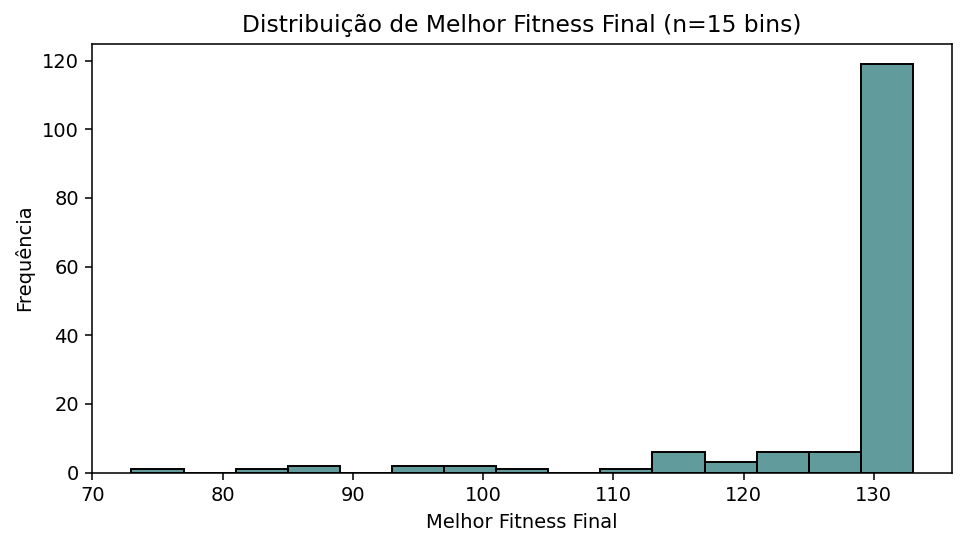

In [31]:
# ...existing code...
# Histograma de melhor_fitness_final (15 bins)
plt.figure(figsize=(7,4), dpi=140)
sns.histplot(data=df_resumo, x="melhor_fitness_final", bins=15, color="#2C7A7B", edgecolor="black")
plt.xlabel("Melhor Fitness Final")
plt.ylabel("Frequência")
plt.title("Distribuição de Melhor Fitness Final (n=15 bins)")
plt.tight_layout()
plt.show()
# ...existing code...

In [32]:
df_resumo

,execucao,melhor_fitness_final,geracao_melhor_global,tempo_total_execucao,n_formigas,n_geracoes,alfa,beta,taxa_evaporacao,tempo_total_seg,tempo_medio_por_geracao,tempo_ate_convergencia
0,1,133,4,4.360824,11,100,2.172852,3.879932,0.488908,4.315808,0.086316,0.345265
1,2,133,1,31.810278,81,100,6.767804,5.984480,0.203642,31.768352,0.635367,0.635367
2,3,131,2,32.989016,92,100,5.158982,2.409363,0.362220,32.955208,0.659104,1.318208
3,4,131,3,27.870966,82,100,4.674938,1.939307,0.112318,27.832510,0.556650,1.669951
4,5,131,3,9.798199,28,100,3.170355,3.368044,0.456105,9.758984,0.195180,0.585539
...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,133,1,19.678536,96,100,0.861867,4.428434,0.222804,19.659440,0.393189,0.393189
146,147,125,2,20.889746,97,100,6.550561,1.625050,0.147983,20.871271,0.417425,0.834851
147,148,133,2,20.301604,93,100,3.452175,4.110052,0.315655,20.258142,0.405163,0.810326
148,149,133,1,9.371248,38,100,6.365404,6.532992,0.322166,9.349915,0.186998,0.186998


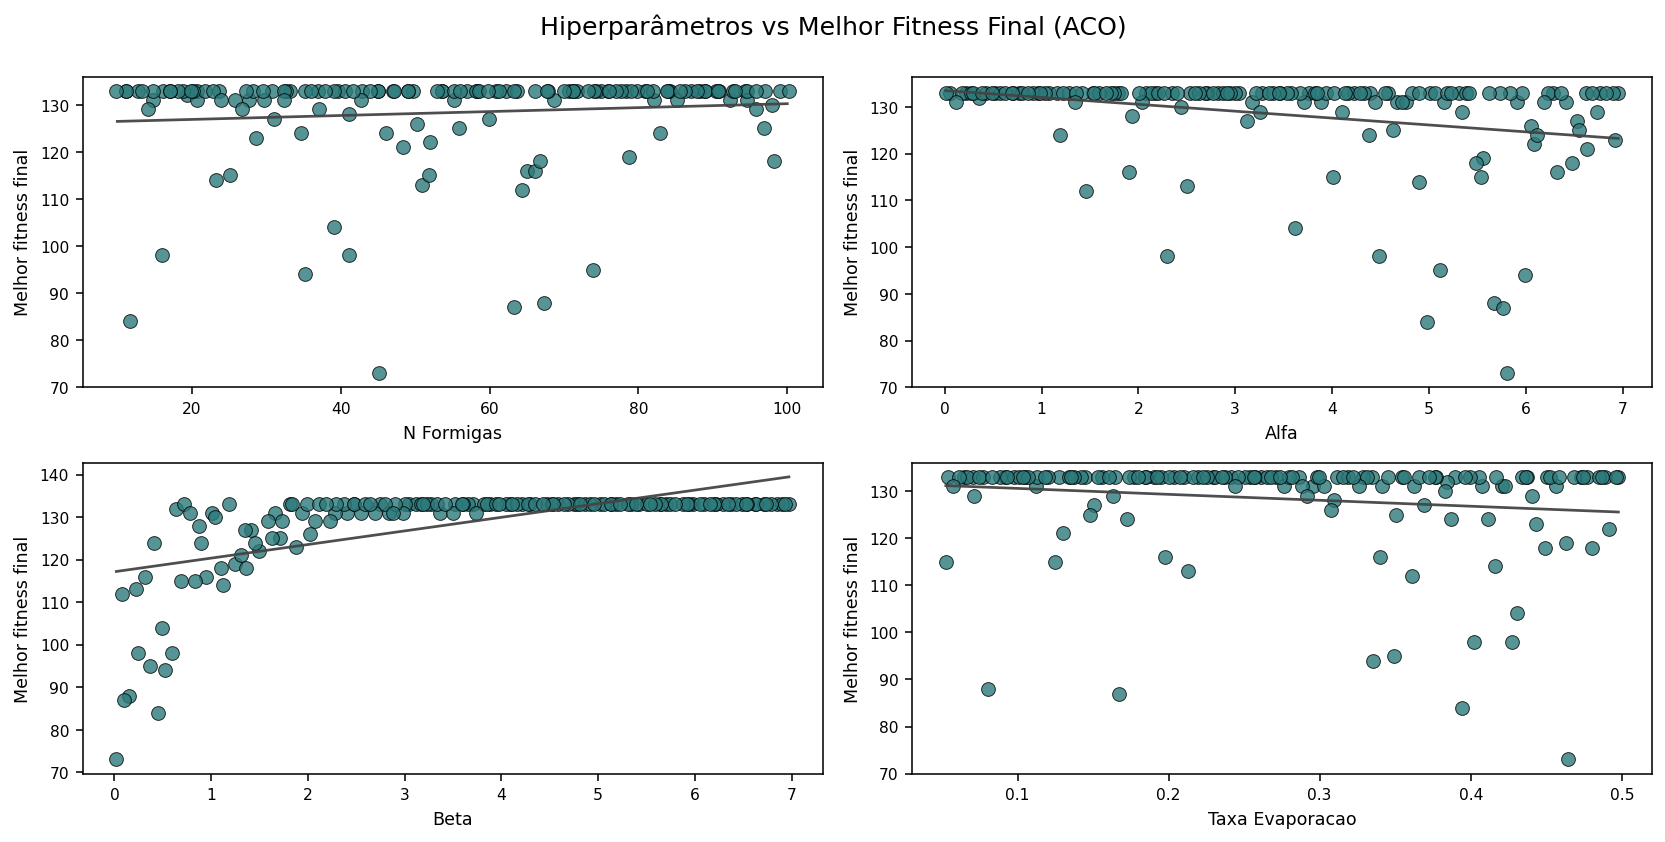

In [35]:
# ...existing code...
# Dispersão dos hiperparâmetros vs melhor_fitness_final (sem flags)
vars_x = ["n_formigas","alfa","beta","taxa_evaporacao"]
plt.style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=140)
axes = axes.flatten()
rng = np.random.default_rng(42)

for ax, col in zip(axes, vars_x):
    x = df_resumo[col].astype(float)
    y = df_resumo["melhor_fitness_final"].astype(float)

    x_plot = x.copy()
    if col == "n_formigas":
        x_plot = x_plot + rng.uniform(-0.4, 0.4, size=len(x_plot))  # jitter leve

    ax.scatter(
        x_plot, y,
        s=50,
        facecolor="#2C7A7B",
        edgecolor="black",
        alpha=0.8,
        linewidth=0.5
    )

    # Linha de tendência (média por valor discreto ou regressão linear)
    if x.nunique() > 1:
        if x.nunique() <= 5:
            meio = (df_resumo.groupby(col)["melhor_fitness_final"]
                    .mean()
                    .reset_index()
                    .sort_values(col))
            ax.plot(meio[col], meio["melhor_fitness_final"],
                    color="#444444", lw=1.4, alpha=0.95)
        else:
            a, b = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 60)
            y_line = a * x_line + b
            ax.plot(x_line, y_line, color="#444444", lw=1.4, alpha=0.95)

    ax.set_xlabel(col.replace("_", " ").title(), fontsize=9)
    ax.set_ylabel("Melhor fitness final", fontsize=9)
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_color("black")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=8)

fig.suptitle("Hiperparâmetros vs Melhor Fitness Final (ACO)", fontsize=13, y=0.995)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
# ...existing code...
# Dispersão dos hiperparâmetros vs melhor_fitness_final (sem flags)
vars_x = ["n_formigas","alfa","taxa_evaporacao", "tempo_ate_convergencia"]
plt.style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=140)
axes = axes.flatten()
rng = np.random.default_rng(42)

for ax, col in zip(axes, vars_x):
    x = df_resumo[col].astype(float)
    y = df_resumo["melhor_fitness_final"].astype(float)

    x_plot = x.copy()

    ax.scatter(
        x_plot, y,
        s=50,
        facecolor="#2C7A7B",
        edgecolor="black",
        alpha=0.8,
        linewidth=0.5
    )

    # Linha de tendência (média por valor discreto ou regressão linear)
    if x.nunique() > 1:
        if x.nunique() <= 5:
            meio = (df_resumo.groupby(col)["melhor_fitness_final"]
                    .mean()
                    .reset_index()
                    .sort_values(col))
            ax.plot(meio[col], meio["melhor_fitness_final"],
                    color="#444444", lw=1.4, alpha=0.95)
        else:
            a, b = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 60)
            y_line = a * x_line + b
            ax.plot(x_line, y_line, color="#444444", lw=1.4, alpha=0.95)

    ax.set_xlabel(col.replace("_", " ").title(), fontsize=9)
    ax.set_ylabel("Melhor fitness final", fontsize=9)
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_color("black")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=8)

fig.suptitle("Hiperparâmetros vs Melhor Fitness Final (ACO)", fontsize=13, y=0.995)
plt.tight_layout()
plt.show()
# ...existing code...

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_2352\1992492674.py:81: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



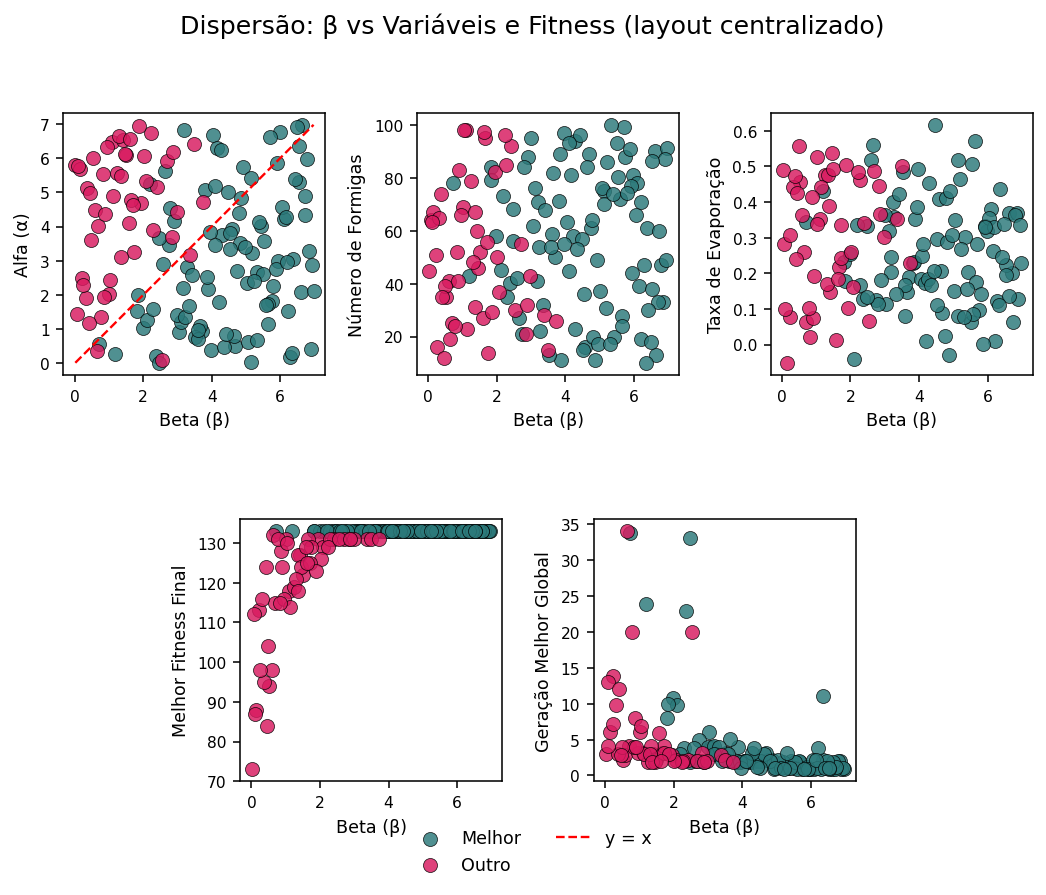

In [ ]:
# ...existing code...
# Versão reorganizada dos 5 gráficos (layout centrado e harmonia visual)
import statsmodels.formula.api as smf
best_fit = df_resumo["melhor_fitness_final"].max()
df_resumo["flag_best"] = np.where(df_resumo["melhor_fitness_final"] == best_fit, "Melhor", "Outro")
df_resumo["flag_best_bin"] = (df_resumo["flag_best"] == "Melhor").astype(int)

palette = {"Melhor": "#2C7A7B", "Outro": "#D81B60"}
rng = np.random.default_rng(42)

plots = [
    ("alfa", "Alfa (α)"),
    ("n_formigas", "Número de Formigas"),
    ("taxa_evaporacao", "Taxa de Evaporação"),
    ("melhor_fitness_final", "Melhor Fitness Final"),
    ("geracao_melhor_global", "Geração Melhor Global")
]

# Usar GridSpec: primeira linha com 3, segunda linha com 2 centralizados
from matplotlib import gridspec
fig = plt.figure(figsize=(9.2, 6.2), dpi=140)
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1], hspace=0.55, wspace=0.55)

axes = []
# Linha 1: colunas 0-1, 2-3, 4-5
axes.append(fig.add_subplot(gs[0, 0:2]))
axes.append(fig.add_subplot(gs[0, 2:4]))
axes.append(fig.add_subplot(gs[0, 4:6]))
# Linha 2 central: ocupar colunas 1-2 e 3-4 (deixa margem lateral)
axes.append(fig.add_subplot(gs[1, 1:3]))
axes.append(fig.add_subplot(gs[1, 3:5]))

for ax, (ycol, ylabel) in zip(axes, plots):
    x = df_resumo["beta"].astype(float)
    y = df_resumo[ycol].astype(float)

    # Jitter discreto
    if ycol in ["n_formigas", "taxa_evaporacao", "geracao_melhor_global"]:
        y = y + rng.uniform(-0.15, 0.15, size=len(y))

    # Plot por flag
    for flag, sub in df_resumo.groupby("flag_best"):
        x_sub = sub["beta"].astype(float)
        y_sub = sub[ycol].astype(float)
        if ycol in ["n_formigas", "taxa_evaporacao", "geracao_melhor_global"]:
            y_sub = y_sub + rng.uniform(-0.15, 0.15, size=len(y_sub))
        ax.scatter(
            x_sub, y_sub,
            s=52,
            facecolor=palette[flag],
            edgecolor="black",
            linewidth=0.4,
            alpha=0.83,
            label=flag if ax is axes[0] else None
        )

    # Reta y=x só para alfa
    if ycol == "alfa":
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        lim_min = max(min(xmin, ymin), x.min())
        lim_max = min(max(xmax, ymax), x.max())
        ax.plot([lim_min, lim_max], [lim_min, lim_max],
                color="red", lw=1.2, ls="--", label="y = x")

    ax.set_xlabel("Beta (β)", fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_facecolor("white")
    for sp in ax.spines.values():
        sp.set_color("black")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=8)

    # Manter aspecto visual similar
    ax.set_box_aspect(1)
# Legenda combinada simplificada
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=9, bbox_to_anchor=(0.5, -0.015))

fig.suptitle("Dispersão: β vs Variáveis e Fitness", fontsize=13, y=0.995)
plt.tight_layout(rect=(0.02, 0.03, 0.98, 0.96))
plt.show()
# ...existing code...

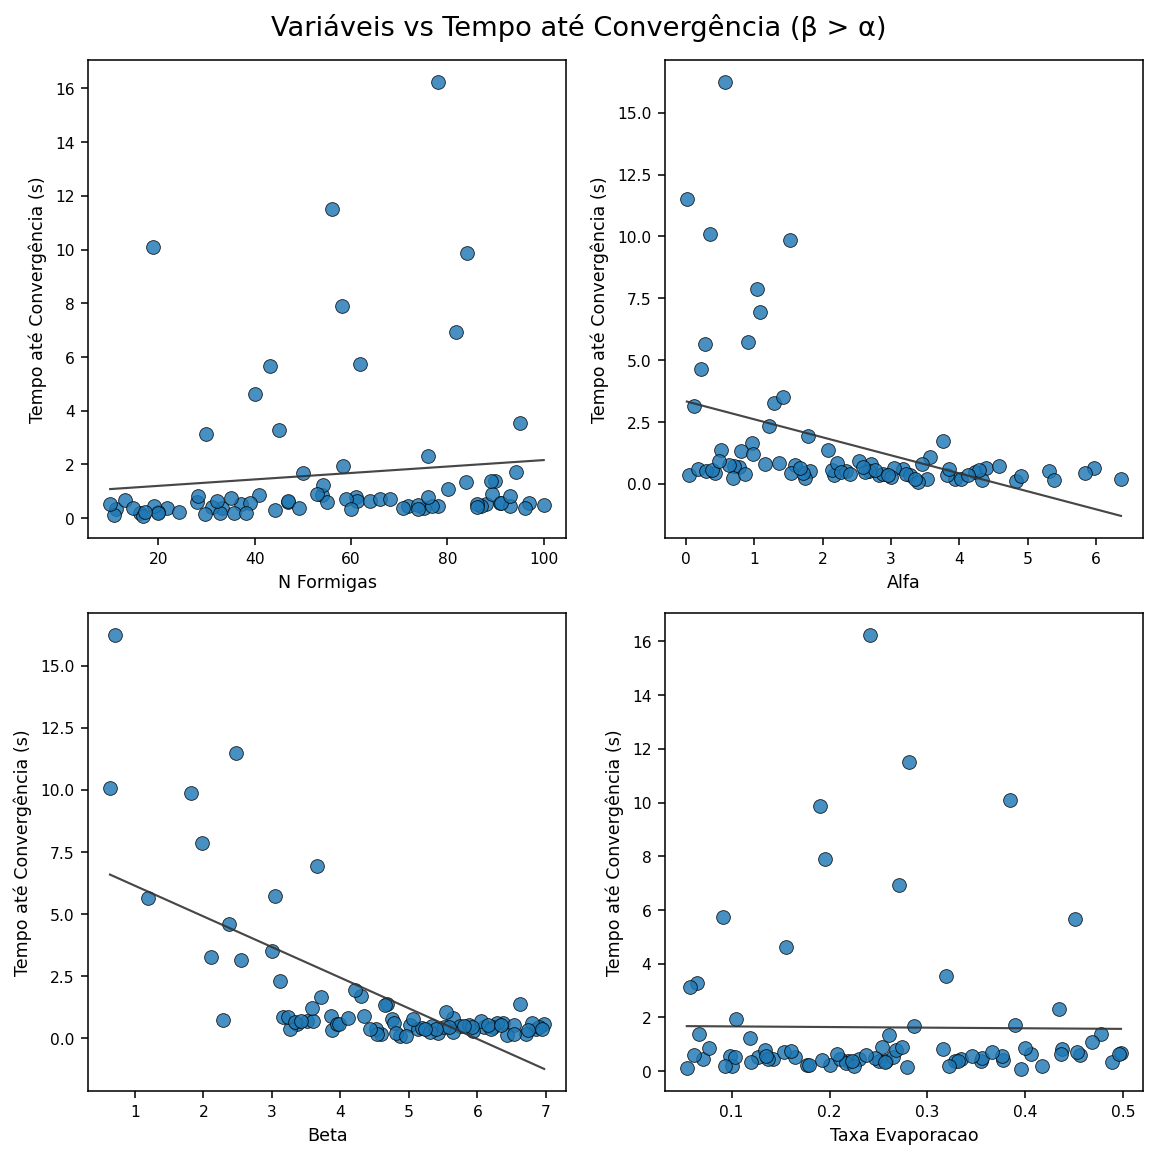

In [ ]:
df_beta_gt_alfa = df_resumo[df_resumo["beta"] > df_resumo["alfa"]].copy()

vars_x= [
    "n_formigas","alfa","beta","taxa_evaporacao"]
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2*n_cols, 4.2*n_rows), dpi=140)
axes_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
for ax in axes_list[len(vars_x):]:
    ax.remove()
rng = np.random.default_rng(42)
used_axes = axes_list[:len(vars_x)]
y = df_beta_gt_alfa["tempo_ate_convergencia"].astype(float)
for ax, col in zip(used_axes, vars_x):
    x = df_beta_gt_alfa[col].astype(float)
    x_plot = x.copy()
    if col in ["n_formigas","geracao_melhor_global"]:
        x_plot = x_plot + rng.uniform(-0.25,0.25,size=len(x_plot))
    ax.scatter(
        x_plot, y,
        s=50, facecolor="#1f78b4",
        edgecolor="black", linewidth=0.45, alpha=0.82
    )
    if x.nunique() > 1 and y.nunique() > 1:
        a,b = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 120)
        ax.plot(x_line, a*x_line + b, color="#333333", lw=1.1, alpha=0.9)
    ax.set_xlabel(col.replace("_"," ").title(), fontsize=9)
    ax.set_ylabel("Tempo até Convergência (s)", fontsize=9)
    ax.set_facecolor("white")
    for sp in ax.spines.values():
        sp.set_color("black")
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(False)
    ax.set_box_aspect(1)
fig.suptitle("Variáveis vs Tempo até Convergência (β > α)", fontsize=14, y=0.98)
plt.tight_layout()